# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 3 - Segmentation and Homographies
---

### <a style='color:red'> Due Date: 14.8.2024 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

### Quick note
in this task, you will be required to use Deep learning segmentation methods. for that, you can use any method that has been presented in class, including but not limited to SegmentAnything,Mask-RCNN, and more.
if you choose SegmentAnything, use the following link to see an example for usage: <a href="https://github.com/facebookresearch/segment-anything">link here</a>. Note: if you use SAM, you must in order to use it, download pre-trained weights. please note in the report which model-type you chose, the link to the download. DO NOT include the pre-traiend weights

#### Installing segment-anything package:

In [1]:
! pip install git+https://github.com/facebookresearch/segment-anything.git 

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\rom\appdata\local\temp\pip-req-build-60j_r4cm
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\Rom\AppData\Local\Temp\pip-req-build-60j_r4cm'


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import glob
from sklearn.cluster import KMeans
import requests
from segment_anything import SamPredictor, sam_model_registry
from ultralytics import YOLO
from frame_video_convert import video_to_image_seq, image_seq_to_video


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

#### Part 1 - Classic Vs. Deep Learning-based Semantic Segmentation
---
In this part you are going to compare classic methods for segmentation to deep learning-based methods. 

1. Load the images in the `./data/frogs` and `./data/horses` folders and display them.
2. Pick 1 classic method for segmentation and 1 deep learning-based method and segment the given images. Display the results.
    * **Briefly** summarize each method you picked and discuss the advantages and disadvantages of each method. In your answer, relate to the results you received in this section.
    * You can use a ready implementation from the internet or OpenCV, no need to implement it yourselves.
    * Note: the classic method **must not** use any neural network.
3. Pick 3 images (download from the internet or take them yourself) that satisfy the following, and dispaly them:
    * One image of a living being (human, animal,...).
    * One image of commonly-used object (car, chair, smartphone, glasses,...).
    * One image of not-so-commonly-used object (fire extinguisher, satellite,... **BE CREATIVE**).
4. Apply each method (one classic and one deep learning-based) on the 3 images. Display the results (mask and segmented image).
    * Which method performed better on each image? Describe your thoughts on why one method is better than the other.
    * For the classic method you can change parameters per-image, document them in the report.
    * You can add manual post-processing to get a mask if needed. If you do that, document in your report "how hard" you had to work in the post-processing stage, as it's an indication of the quality of the method.
5. As you probably have noticed, segmentation can be rough around the edges, i.e., the mask is not perfect and may be noisy around the edges. What can be done to fix or at least alleviate this problem? Your suggestions can be in pre-processing, inside the segmentation algorithm or in post-processing.

##### Section 1

In [22]:
def display_images(images, title):
    num_images = len(images)
    # Determine the layout of the figure
    if num_images == 1:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(images[0])
        ax.axis('off')
    else:
        num_rows = int(num_images ** 0.5)
        num_cols = (num_images + num_rows - 1) // num_rows
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
        
        # Display the images
        for i, ax in enumerate(axes.flat):
            if i < num_images:
                ax.imshow(images[i])
                ax.axis('off')
            else:
                fig.delaxes(ax)
    
    # Set the title and show the figure
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

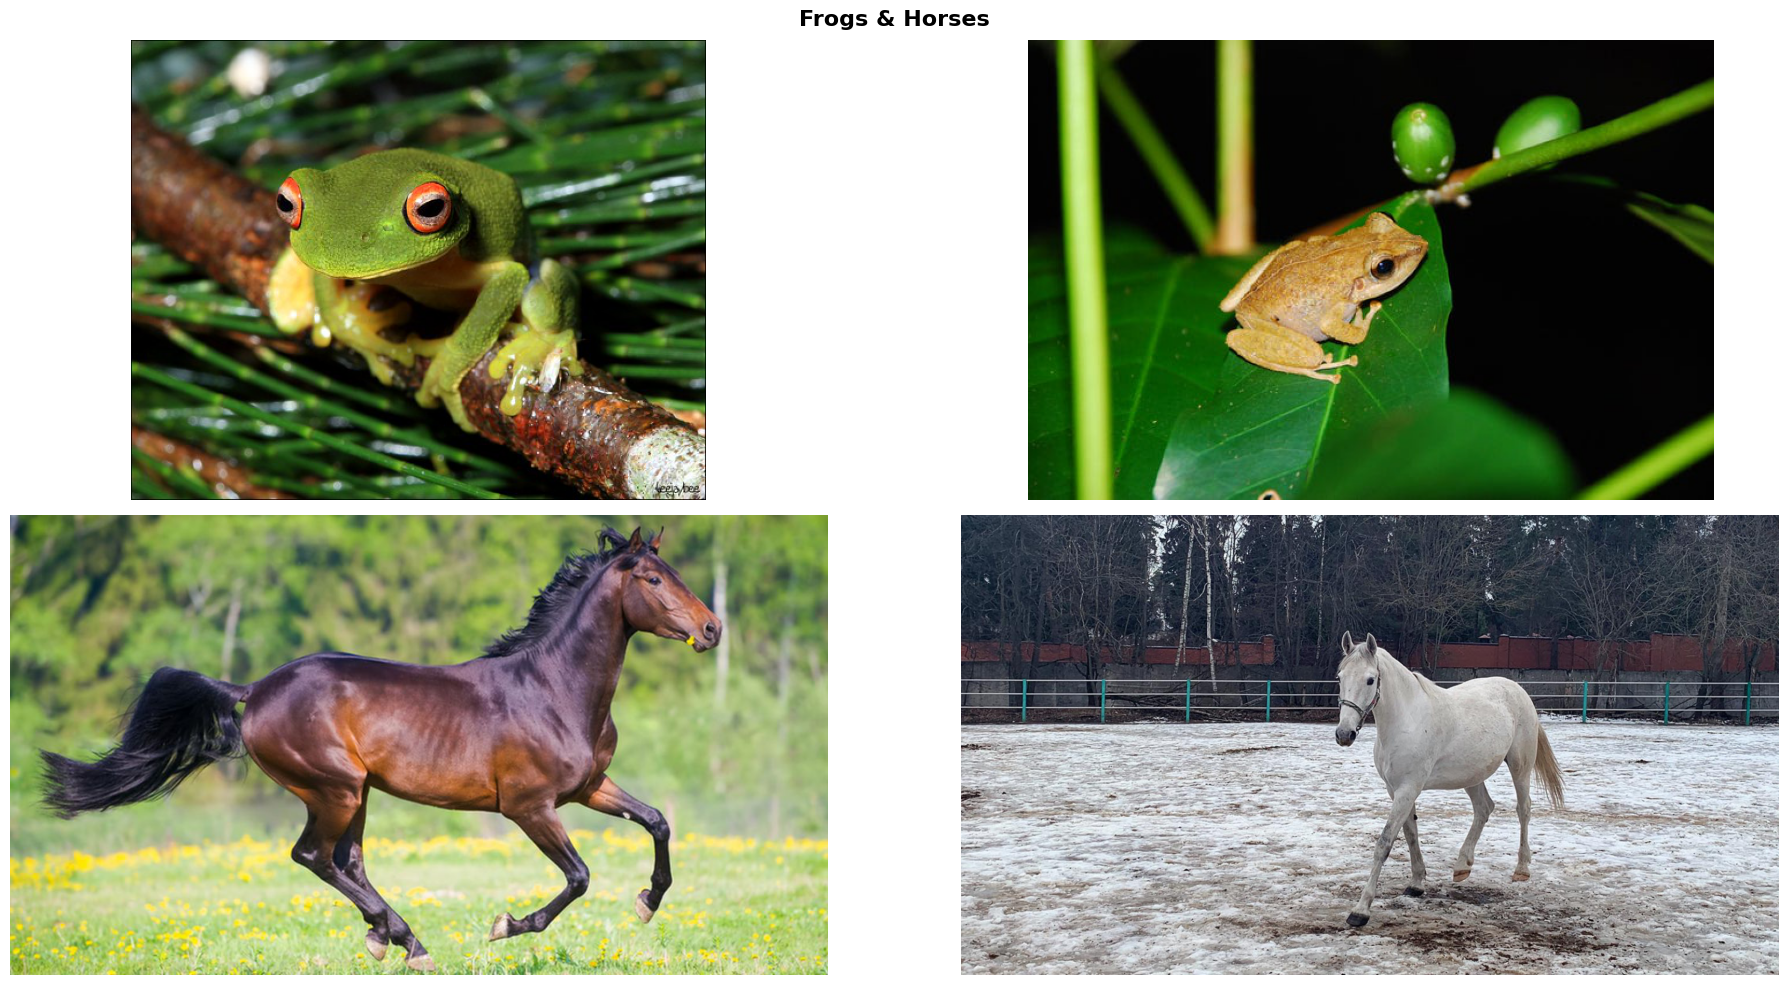

In [23]:
# load the images in ../data/frogs and ../data/horses and display them
frogs = [Image.open(path).convert("RGB") for path in glob.glob('../data/frogs/*')]
horses = [Image.open(path).convert("RGB") for path in glob.glob('../data/horses/*')]

display_images(frogs + horses, "Frogs & Horses")

##### Section 2

In [5]:
def segment_image_kmeans(image, n_clusters=2):
    img_array = np.array(image)
    img_reshape = img_array.reshape((-1, 3))
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=20).fit(img_reshape)
    labels = kmeans.labels_.reshape(img_array.shape[:2])

    segmented_image = np.zeros_like(img_array)
    for i in range(n_clusters):
        segmented_image[labels == i] = kmeans.cluster_centers_[i]
    
    return segmented_image

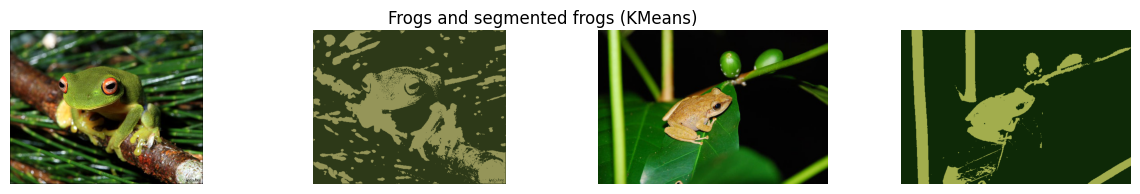

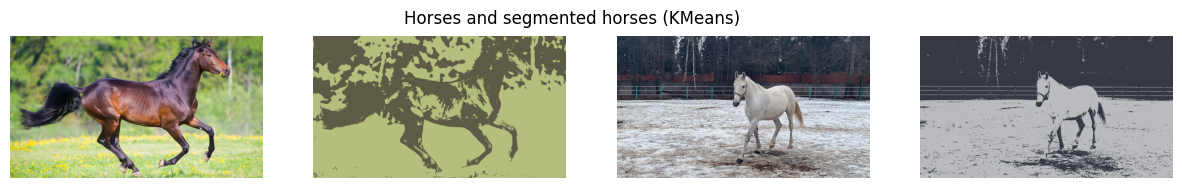

In [7]:
# Segment and display images, present each image with its original and segmented versions
segmented_frogs = [segment_image_kmeans(img) for img in frogs]
segmented_horses = [segment_image_kmeans(img) for img in horses]

frogs_and_segmented_frogs = [img for pair in zip(frogs, segmented_frogs) for img in pair]
horses_and_segmented_horses = [img for pair in zip(horses, segmented_horses) for img in pair]

display_images(frogs_and_segmented_frogs, 'Frogs and segmented frogs (KMeans)')
display_images(horses_and_segmented_horses, 'Horses and segmented horses (KMeans)')

In [8]:
file_url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
local_filename = '../data/sam_vit_h_4b8939.pth'

if not os.path.exists(local_filename):
    response = requests.get(file_url, stream=True)
    if response.status_code == 200:
        with open(local_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"File downloaded and saved as {local_filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

In [26]:
SAM = sam_model_registry["vit_h"](checkpoint="../data/sam_vit_h_4b8939.pth").to(device)
segment_predictor = SamPredictor(SAM)

# # load yolov5 model
box_predictor = YOLO('../data/yolov5nu.pt').to(device)

PRO TIP  Replace 'model=../data/yolov5n.pt' with new 'model=../data/yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [10]:
def segment_image_sam(image):
    image_as_np = np.array(image)
    segment_predictor.set_image(image_as_np)
    bbox_predictions = box_predictor(image_as_np)
    
    if len(bbox_predictions[0].boxes.data) > 0 and len(bbox_predictions[0].boxes.data[0]) >= 4:
        bounding_box = bbox_predictions[0].boxes.data[0][:4].cpu().numpy().astype(int)
        segmentation_masks, _, _ = segment_predictor.predict(box=bounding_box[None, :])
    else:
        center_point = np.array([[int(image_as_np.shape[0] / 2), int(image_as_np.shape[1] / 2)]])
        center_label = np.array([1])
        segmentation_masks, _, _ = segment_predictor.predict(point_coords=center_point, point_labels=center_label)

    return segmentation_masks[-1]

In [29]:
print(device)

cuda


In [27]:
# Segment and display images, present each image with its original and segmented versions
segmented_frogs = [segment_image_sam(img) for img in frogs]
segmented_horses = [segment_image_sam(img) for img in horses]


0: 512x640 (no detections), 112.5ms
Speed: 4.0ms preprocess, 112.5ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 bird, 1 sports ball, 78.8ms
Speed: 3.0ms preprocess, 78.8ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 horse, 114.2ms
Speed: 2.5ms preprocess, 114.2ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 horse, 51.0ms
Speed: 2.6ms preprocess, 51.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


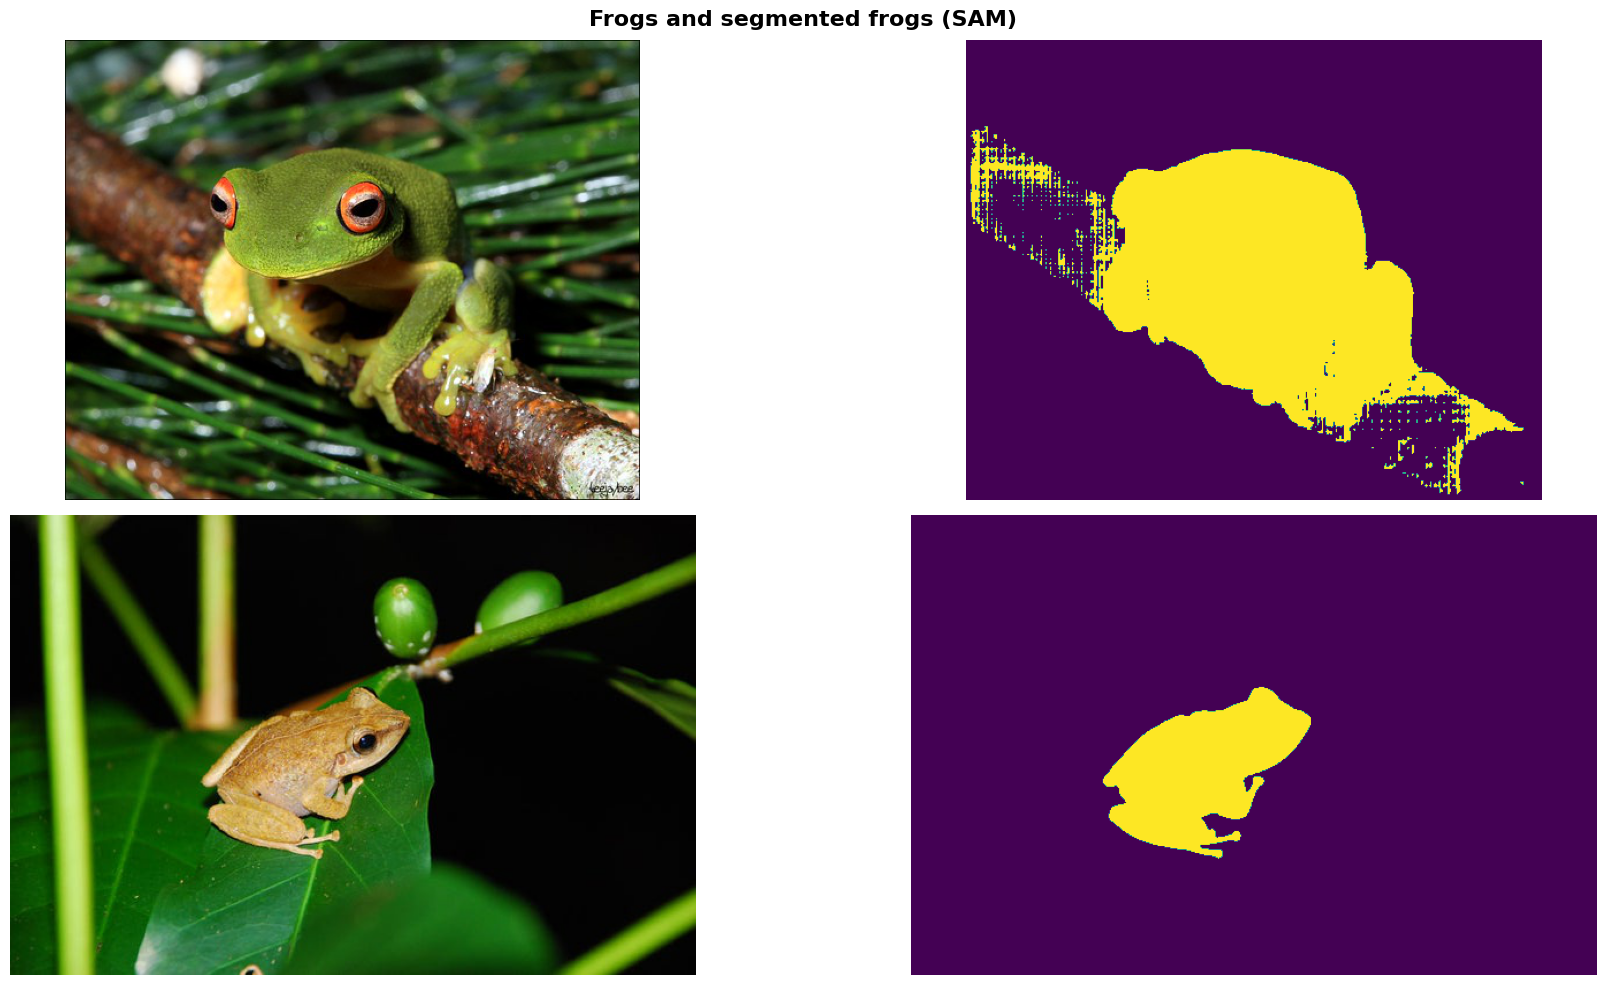

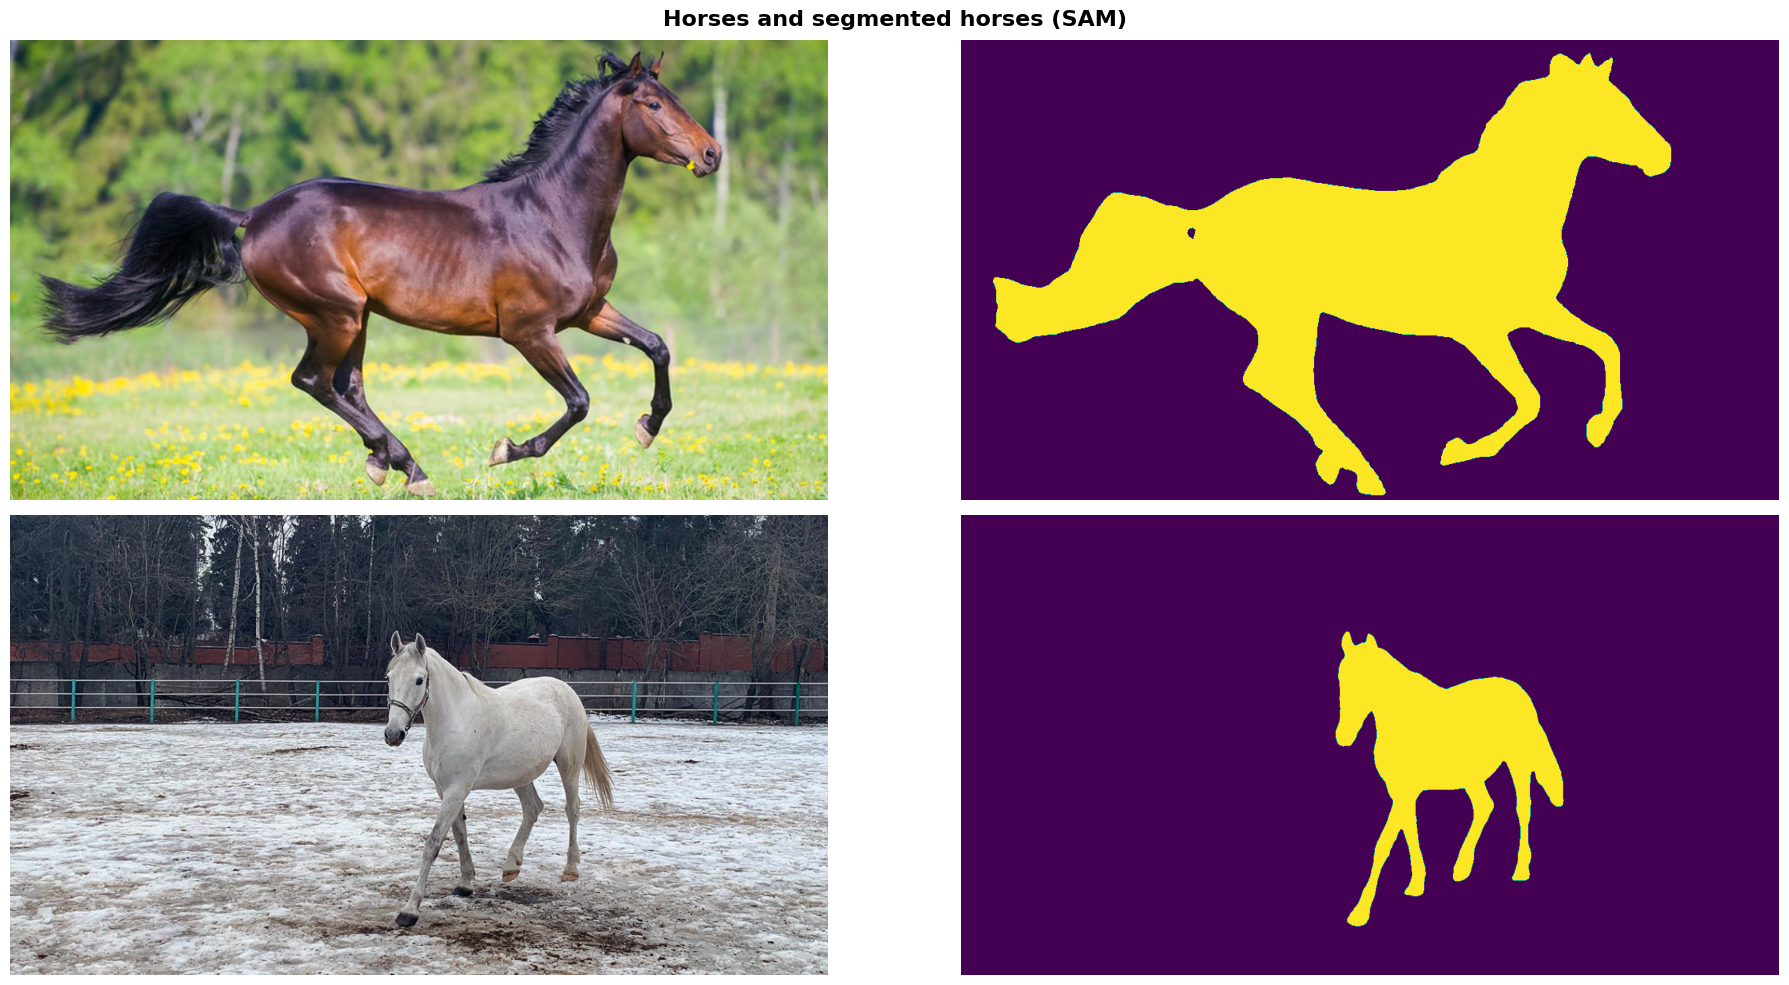

In [28]:
frogs_and_segmented_frogs = [img for pair in zip(frogs, segmented_frogs) for img in pair]
horses_and_segmented_horses = [img for pair in zip(horses, segmented_horses) for img in pair]

display_images(frogs_and_segmented_frogs, 'Frogs and segmented frogs (SAM)')
display_images(horses_and_segmented_horses, 'Horses and segmented horses (SAM)')

##### Section 3

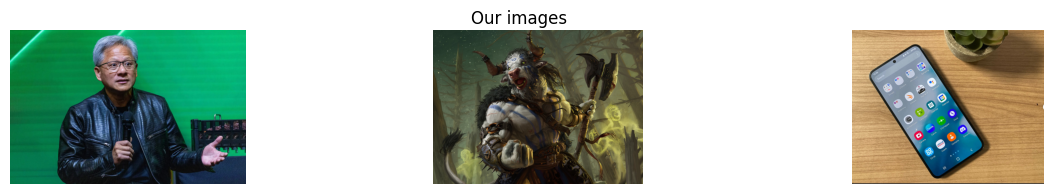

In [12]:
our_images = [Image.open(path).convert("RGB") for path in glob.glob('../data/my_data/our_images/*')]
display_images(our_images, 'Our images')

##### Section 4


0: 448x640 1 person, 80.2ms
Speed: 5.0ms preprocess, 80.2ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 (no detections), 112.0ms
Speed: 6.0ms preprocess, 112.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 1 cell phone, 115.5ms
Speed: 7.5ms preprocess, 115.5ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)


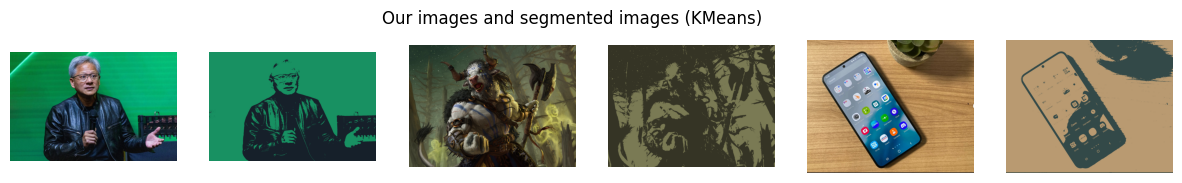

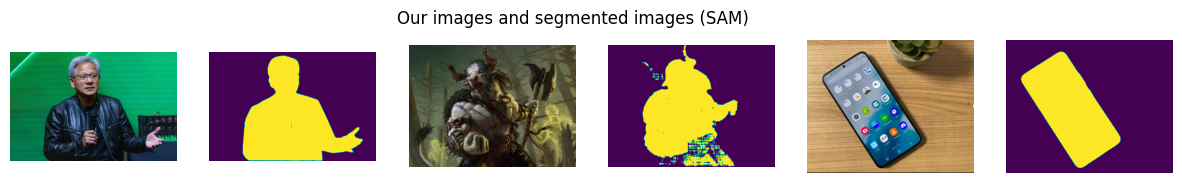

In [13]:
# Segment our images using KMeans and SAM and display the results
segmented_our_images_kmeans = [segment_image_kmeans(img) for img in our_images]
segmented_our_images_sam = [segment_image_sam(img) for img in our_images]

our_images_and_segmented_images_kmeans = [img for pair in zip(our_images, segmented_our_images_kmeans) for img in pair]
our_images_and_segmented_images_sam = [img for pair in zip(our_images, segmented_our_images_sam) for img in pair]

display_images(our_images_and_segmented_images_kmeans, 'Our images and segmented images (KMeans)')
display_images(our_images_and_segmented_images_sam, 'Our images and segmented images (SAM)')

##### Section 5

#### Part 2 - Jurrasic Fishbach
---
In this part you are going to apply segmentation on a video, and integrate with other elements.

<img src="https://lh3.googleusercontent.com/5zF16wl-tdE1FZCuVsrNxHWzfa6uXo4hYE_BGabKnGovw2W-bIT9gnZlAgU8nUoK=w412-h220-rw">

1. Film a short video of yourself (you can use your phone for that), but without too much camera movement. You on the other hand, can move however you want (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution (lower than 720p ~ 1280x720 pixles). You can use the function in `./code/frame_video_convert.py` to help you. Display 2 frames in the report.
2. Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report. 
3. Pick one of the objects in the supplied videos file (`./data/video_models`), convert it to images and segement it out using one of the methods from Part 1(classic or deep). Display 2 frames in the report. You can choose another object from: https://pixabay.com/videos/search/green%20screen/.
    * Explain how you performed the sementation for this specific type of video (i.e., green-screen videos). Did you  use a simple/classic method? Deep method? Combined both?
4. Put it all together - pick a background, put yourself and the segemented object on the background. Stich it frame-by-frame (don't make the video too long or it will take a lot of time, 10secs maximum). Display 2 frames of the result in your report. Convert the frames back to video. You can use the function in `frame_video_convert.py` to help you.
    * Tip: To make it look good, you can resize the images, create a mapping from pixel locations in the original image to pixels locations in the new image.
    * You should submit the final video in the `./output` folder (**MANDATORY**).
    * We expect some creative results, this can benefit you a lot when you want to demonstrate your Computer Vision abilities.

##### Section 1

In [16]:
# convert video to image sequence
os.makedirs('../data/my_data/roi_video_frames', exist_ok=True)
video_to_image_seq('../data/my_data/roi_video.mp4', '../data/my_data/roi_video_frames')

converting video to frames...
total frames:  170


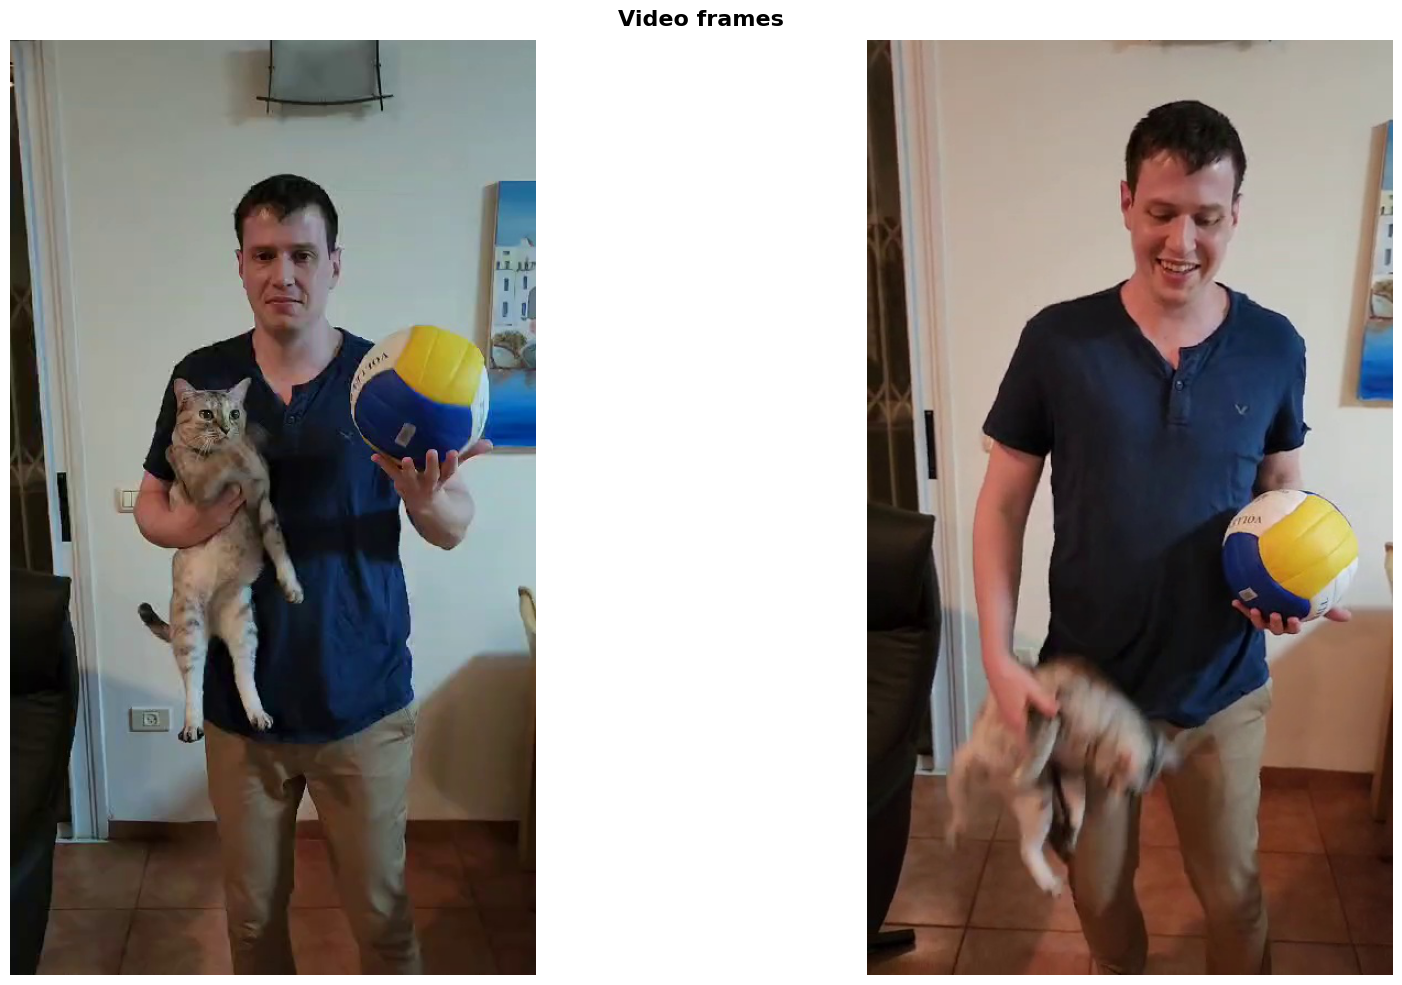

In [25]:
video_frames = [Image.open(path).convert("RGB") for path in glob.glob('../data/my_data/roi_video_frames/*')]
display_images([video_frames[0],video_frames[-1]], 'Video frames')

##### Section 2

In [ ]:
# Segment the video frames using SAM and display the results
segmented_video_frames_sam = [segment_image_sam(img) for img in video_frames]
os.makedirs('../data/my_data/segmented_roi_video_frames', exist_ok=True)
for i, img in enumerate(segmented_video_frames_sam):
    img.save(f'../data/my_data/segmented_roi_video_frames/{i}.jpg')
    
display_images([video_frames[0], segmented_video_frames_sam[0]], 'First video frame and segmented version (SAM)')
display_images([video_frames[-1], segmented_video_frames_sam[-1]], 'Last video frame and segmented version (SAM)')

##### Section 3

In [ ]:
os.makedirs('../data/my_data/dancing_man_video_frames', exist_ok=True)
video_to_image_seq('../data/video_models/dancing_man_model.mp4', '../data/my_data/dancing_man_video_frames')

video_frames = [Image.open(path).convert("RGB") for path in glob.glob('../data/my_data/dancing_man_video_frames/*')]
                                                                      
# Segment the video frames using SAM
segmented_dancing_video_frames_sam = [segment_image_sam(img) for img in video_frames]
for i, img in enumerate(segmented_dancing_video_frames_sam):
    img.save(f'../data/my_data/segmented_dancing_man_video_frames/{i}.jpg')

display_images([video_frames[0], segmented_dancing_video_frames_sam[0]], 'First video frame and segmented version (SAM)')
display_images([video_frames[-1], segmented_dancing_video_frames_sam[-1]], 'Last video frame and segmented version (SAM)')


#### Part 3 - Planar Homographies: 
---
After we saw how descriptors are implemented and performed, now we will see how to use them for homographis.

In this part you will implement an image stitching algorithm, and will learn how to stitch several images of the same scene into a panorama. First, we’ll concentrate on the case of two images and then extend to several images.

For the following tasks:
- **You are not allowed to use OpenCV/Scipy or any other "ready to use" functions when you are asked to implement a function (you can still use the functions to save and load images).**
- For each step add illustration images to your report.
- You can demonstrate your steps using `incline_L.jpg` and `incline_R.jpg` images, or any other relevant example images (unless specified otherwise).

#### Planar Homographies: Theory review
---
Suppose we have two cameras $C_1$ and $C_2$ looking at a common plane $Π$ in 3D space. Any 3D point $P$ on $Π$ generates a projected 2D point located at $p ≡ (x,y,1)^T$ on the ﬁrst camera $C_1$ and $q ≡ (u,v,1)^T$ on the second camera $C_2$. Since $P$ is conﬁned to the plane $Π$, we expect that there is a relationship between $p$ and $q$. In particular, there exists a common $3 × 3$ matrix $H$, so that for any $P$, the following conditions holds: 
\begin{align}
\text{(1) }q ≡ Hp
\end{align}



We call this relationship *'planar homography'*. Recall that both $p$ and $q$ are in homogeneous coordinates and the equality $≡$ means $p$ is proportional to $Hq$ (recall homogeneous coordinates). It turns out this relationship is also true for cameras that are related by pure rotation without the planar constraint. 

##### **Matched points:**
---

Given a set of points $p = \{p_1,p_2,...,p_N\}$ in an image taken by camera $C_1$ and corresponding points $q = \{q_1,q_2,...,q_N\}$ in an image taken by $C_2$. Suppose we know there exists an unknown homography $H$ between corresponding points for all $i ∈\{1,2,...,N\}$. This formally means that $\exists H$ such that: 

 
\begin{equation*} 
\text{(2) } q^i ≡ Hp^i
\end{equation*}


where $p^i = (x_i,y_i,1)$ and $q^i = (u_i,v_i,1)$ are homogeneous coordinates of image points each from an image taken with $C_1$ and $C_2$ respectively.

* Given $N$ correspondences in $p$ and $q$ and using Equation 2, we derived a set of $2N$ independent linear equations in the form:


\begin{equation*} 
\text{(3) } Ah = 0
\end{equation*}


where $h$ is a vector of the elements of $H$ and $A$ is a matrix composed of elements derived from the point coordinates:  

$$ \begin{bmatrix} &&&&&\dots\\ x_i & y_i & 1 & 0 & 0 & 0 & -x_iu_i&-y_iu_i& -u_i \\ 0&0&0&x_i&y_i&1 & -x_iv_i&-y_iv_i& -v_i \\ &&&&&\dots \end{bmatrix} 
\begin{bmatrix} h_1\\h_2\\h_3\\ h_4 \\ h_5 \\ h_6 \\ h_7\\h_8\\h_9\\ \end{bmatrix} = \begin{bmatrix} \dots \\ 0 \\ 0  \\ \dots \end{bmatrix}$$


Each point pair contributes 2 equations and therefore we need at least 4 matches.

#### Planar Homographies: Practice 
---

#### Quick detour- Feature Descriptor
---
In this part we are going to use **Scale-Invariant Feature Transform** (SIFT). We will use OpenCV <a href="https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html">[2]</a> for the implementation.

##### 3.0.1 SIFT Implementaion
---
Implement the following function:


In [ ]:
def SIFT_descriptor(img):
 # Returns the SIFT descriptor keypoints of an image,and draw its detected keypoints
 # INPUTS
 #      img                 - An image read by cv2.imread()
 # OUTPUTS
 #      sift_descriptor     - The SIFT descrptor computed by OpenCV
 #      sift_keypoints      - The SIFT keypoints computed by OpenCV
  """
  Your code here
  """
  return sift_keypoints, sift_descriptor

The function get an image ,returns its SIFT descriptor and keypoints, and draw the detected keypoints over the image.

Plot the results obtained for the `model_chickenbroth` image and another `chickenbroth` image (Use the same image from previous section).


* Implementaton guidance:
    * Use `sift = cv2.xfeatures2d.SIFT_create()` to instantiate the SIFT detector. 
    * Detect and compute SIFT keypoints and descriptors by `sift_keypoint, sift_descriptor = sift.detectAndCompute(img,None)`.
    * Draw the keypoints over the image by using `cv2.drawKeypoints()`.


##### 3.1 - Finding corresponding points using SIFT: 
---
Use the guidelines from 3.0.1 and implement the function `getPoints_SIFT()`, which gets two images and outputs `p1,p2` SIFT keypoints, where `p1[j],p2[j]` are pairs of cooresponding points between `im1` and `im2`.

In [ ]:
def getPoints_SIFT(im1, im2):
    """
    Your code here
    """
    return p1,p2

Inputs: `im1` and `im2` are two 2D grayscale images. 

Output: `p1` and `p2` should be $2\times N$ matrices of corresponding $(x,y)^T$ coordinates between two images ($N$ is the number of corrosponding points you want to extract.). 

* You can also use color images instead of grayscale images, just state it in the report.

#### 3.2 - Calculate transformation: 
---

Implement a function that gets a set of matching points between two images and calculates the transformation between them. The transformation should be $3\times3$ $H$ homogenous matrix such that for each point in image $p\in C_1$, there would be a transformation in image $C_2$ such that $p=Hq$, $q\in C_2$.

In [ ]:
def computeH(p1, p2):
    """
    Your code here
    """
    return H2to1

Inputs: `p1` and `p2` should be $2\times N$ matrices of corresponding $(x,y)^T$ coordinates between two images. 

Outputs: `H2to1` should be a $3\times 3$ matrix encoding the homography that best matches the linear equation derived above for Equation 2. 

Hint: Remember that a homography is only determined up to scale. The `numpy`'s functions `eig()` or `svd()` will be useful. Note that this function can be written without an explicit for-loop over the data points.

*Hint for debugging*: A good test of your code is to check that the homography of an image with itself is an identity.

* Implement the computation function, describe and explain your implementation.
* Show that the transformation is correct by selecting arbitrary points in the first image and projecting them to the second image.

#### 3.3 - Image warping:
---
Implement a function that gets an input image and a transformation matrix H and returns the warped image. Please note that after the warping, there will be coordinates that won’t be integers (e.g. sub-pixels). Therefore you will need to interpolate between neighboring pixels. For color images, warp the image for each color channel and then connect them together. In order to avoid holes, use inverse warping.

Implement the wrapping function using numpy and SciPy interp2d() or RegularGridInterpolator() function .
Discuss the influences of different interpolations kinds {‘linear’, ‘cubic’}.
Note: When performing a multi-step algorithm, you need to demonstrate and explain each of those additional improvments.


In [ ]:
def warpH(im1, H, out_size):
    """
    Your code here
    """
    return warp_im1

Inputs: `im1` is a colored image. `H` is a  matrix encoding the homography between im1 and im2. `out_size` is the size of the wanted output (new_imH,new_imW).

Output: `warp_im1` is the warped image im1 including empty background (zeros).

##### 3.4 - Panorama stitching: 
---
Implement a function that gets two images after axis alignment (using OpenCV's `warpPerspective`)
and returns a union of the two. The union should be a simple overlay of one image on the other. Leave empty pixels painted black.


In [ ]:
def imageStitching(img1, warp_img2):
    """
    Your code here
    """
    return panoImg
    

Inputs: `im1`,`warp_img2` are two colored images. 

Output: `panoImg` is the gathered output  panorama.

* Use all the above functions to create a panorama image. Demonstrate and explain you results on the `./data/incline` images.

##### 3.5 - Several Images stitching:
---
* Show the results of the panoramas on the attached images of the beach (`./data/beach`) and Pena National Sintra Palace (`./data/sintra`) for the entire set of images.

* Note: When using SIFT without RANSAC (next section), take the top K matches for estimating the homography. 
  * What happens if you don't do so? Why is that?

##### 3.6 - RANSAC:
---
Added bellow is an implementation of the RANSAC (**Ran**dom **Sa**mple **C**onsensus) algorithm. 
* Explain when it is needed and why.
* Copmare between using RANSAC vs. not using it for creating the panoran images of the beach and SINTRA. Explain.
* What could have been done to get better results?

In [ ]:
def ransacH(p1, p2, nIter=..., tol=...):
    N = p1.shape[1]
    stacked_p2 = np.vstack((p2, np.ones(N)))

    best_inliers_n = 0
    best_inliers = []

    for iter in range(nIter):
        rand_idxs = np.random.choice(np.arange(N), 4, replace=False)
        chosen_p1 = p1[:, rand_idxs]
        chosen_p2 = p2[:, rand_idxs]
        H2to1 = computeH(chosen_p1, chosen_p2)
        p2in1 = H2to1 @ stacked_p2
        p2in1 = p2in1 / p2in1[2, :]
        p2in1 = p2in1[0:2, :]
        L2dists = np.sqrt(np.sum((p2in1 - p1) ** 2, 0))
        inliers = (p1[:, L2dists < tol], p2[:, L2dists < tol])
        n_inliers = np.sum(L2dists < tol)
        if n_inliers > best_inliers_n:
            best_inliers_n = n_inliers
            best_inliers = inliers

    bestH = computeH(best_inliers[0], best_inliers[1])
    return bestH

Inputs: 
* `p1` and `p2` are matrices specifying point locations in each of the images and `p1[j]`,`p2[j]` are matched points between two images.

* `nIter` is the number of iterations to run RANSAC  

* `tol` is the tolerance value for considering a point to be an inlier. 

 * Define your function so that these  `nIter` and  `tol` have reasonable default values.

Outputs: 
* `bestH` is the homography model with the most inliers found during RANSAC

##### 3.7 - Be Creative:
---
* Go out and take at least 3 pictures of a far distance object (e.g. a building), and use what you have learned to create a new excellent Panorama image.
  * Add the resulted image to your report and to the `output` folder.

#### Part 4 - Dry Questions
---
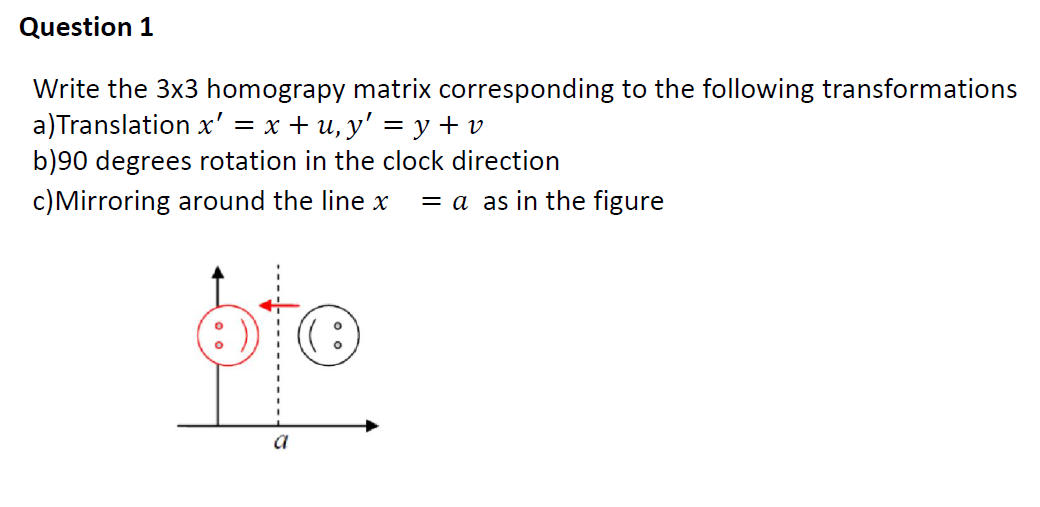



---
## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Images from <a href="http://www.image-net.org/">Imagenet</a>
* Videos from <a href="https://pixabay.com/videos/search/green%20screen/">Pixabay</a>
    * Dinosaur video from <a href="https://sites.google.com/a/sau17.net/modern-media/home/green-screen-animations">Modern Media</a>
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com